# Informed Search

In week 1, we looked at:
- **Uniform-cost search** (dijkstra): $f(n) = g(n)$
- where
    - $f(n)$ is the evaluation function of node $n$
    - $g(n)$ is the cumulative path cost from start node to node $n$

In informed search, we use a heuristic as a hint that can guide us to a solution:
- **Greedy best-first search**: $f(n) = h(n)$
- **A\* search**: $f(n) = g(n) + h(n)$
- where:
    - $h(n)$ is the heuristic of node $n$ (with respect to the goal)

We can represent these 3 methods as 1 formulation: 
- **Weighted A\* search**: $f(n) = (1 - W) \times g(n) + W \times h(n)$
- where:
    - Uniform-cost search if $W = 0$
    - Greedy best-first search if $W = \infty$
    - A* search if $W = 1$

In [1]:
romania_map = dict(
    Arad=["Zerind", "Sibiu", "Timisoara"],
    Bucharest=["Urziceni", "Pitesti", "Giurgiu", "Fagaras"],
    Craiova=["Drobeta", "Rimnicu", "Pitesti"],
    Drobeta=["Mehadia"],
    Eforie=["Hirsova"],
    Fagaras=["Sibiu"],
    Hirsova=["Urziceni"],
    Iasi=["Vaslui", "Neamt"],
    Lugoj=["Timisoara", "Mehadia"],
    Oradea=["Zerind", "Sibiu"],
    Pitesti=["Rimnicu"],
    Rimnicu=["Sibiu"],
    Urziceni=["Vaslui"]
)

romania_loc = dict(
    Arad=(91, 492), Bucharest=(400, 327), Craiova=(253, 288),
    Drobeta=(165, 299), Eforie=(562, 293), Fagaras=(305, 449),
    Giurgiu=(375, 270), Hirsova=(534, 350), Iasi=(473, 506),
    Lugoj=(165, 379), Mehadia=(168, 339), Neamt=(406, 537),
    Oradea=(131, 571), Pitesti=(320, 368), Rimnicu=(233, 410),
    Sibiu=(207, 457), Timisoara=(94, 410), Urziceni=(456, 350),
    Vaslui=(509, 444), Zerind=(108, 531))

In [2]:
from math import dist

class Node:
    def __init__(self, x, y, name=None, neighb=[], is_goal=False) -> None:
        self.x = x
        self.y = y
        self.name = name
        self.is_goal = is_goal
        self.neighb = neighb
    
    # path cost g(n)
    def compute_path_costs(self):
        pos = [self.x, self.y]
        return [dist(pos, [n.x, n.y]) for n in self.neighb] 
    
    # heuristic h(n)
    def compute_heuristic(self, goal):
        return dist([self.x, self.y], [goal.x, goal.y])

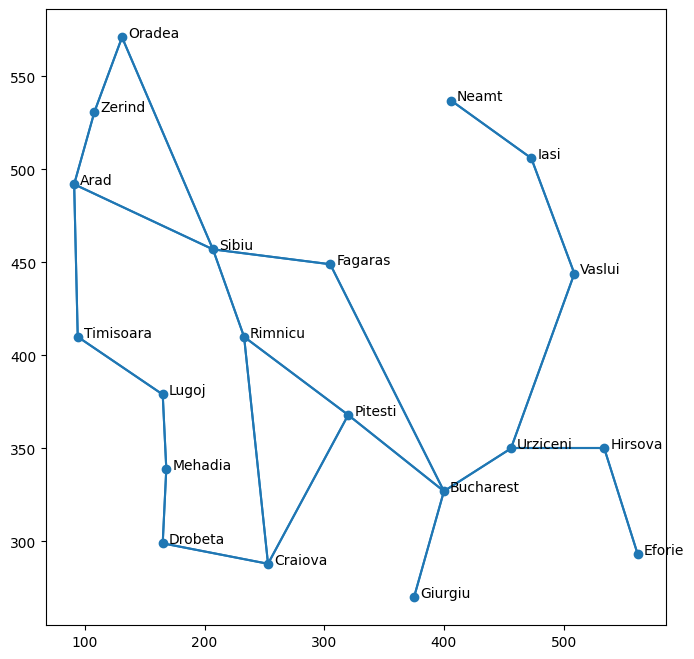

In [3]:
# We will not go into this code in detail, but it is used to visualize the graph
import matplotlib.pyplot as plt

nodes = [Node(x, y, name=name) for name, (x, y) in romania_loc.items()]

for n_i in nodes:
    n_i.neighb = [
        n_j for n_j in nodes 
        if (n_i.name in romania_map and n_j.name in romania_map[n_i.name]) or \
           (n_j.name in romania_map and n_i.name in romania_map[n_j.name])
    ]

x_vals = [n.x for n in nodes]
y_vals = [n.y for n in nodes]

plt.figure(figsize=(8, 8))
plt.scatter(x_vals, y_vals)
for n in nodes:
    plt.annotate(n.name, (n.x+5, n.y))
    for n_i in n.neighb:
        plt.plot([n.x, n_i.x], [n.y, n_i.y], c='C0')

In [4]:
import numpy as np

nodes[1].is_goal = True # Bucharest
start_node = nodes[0]   # Arad

# expand node
[(n.name, c) for n, c in zip(start_node.neighb, start_node.compute_path_costs())], start_node.compute_heuristic(nodes[1])

([('Sibiu', 121.16517651536682),
  ('Timisoara', 82.05485969764375),
  ('Zerind', 42.5440947723653)],
 350.2941620980858)

In [5]:
# Print neighbours with their heuristic to Bucharest
neighb_heuristics = [(n.name, n.compute_heuristic(nodes[1])) for n in start_node.neighb]
print("Neighbours and their heuristics to Bucharest:")
for name, h in neighb_heuristics:
    print(f"{name}: {h:.2f}")

Neighbours and their heuristics to Bucharest:
Sibiu: 232.70
Timisoara: 317.06
Zerind: 356.20


In [6]:
[(n.name, c + n.compute_heuristic(nodes[1])) for n, c in zip(start_node.neighb, start_node.compute_path_costs())]

[('Sibiu', 353.86455339463566),
 ('Timisoara', 399.1116369473975),
 ('Zerind', 398.7462845466563)]

In [7]:
def search(start: Node, graph: list[Node], goal: Node=None, W: float=0.5) -> list[Node]:
    if start.is_goal: return [start]
    
    queue = [(start, 0)] # (node, cumulative distance)
    
    distances = {node: float('infinity') for node in graph}
    distances[start] = 0
    shortest_path = {}
    
    while len(queue) != 0:
        current_node, current_distance = queue.pop(0)
        
        if current_node.is_goal: break

        # current distance larger than saved distance, then it is not possible to optimize 
        # we will have to backtrack
        if current_distance > distances[current_node]: 
            continue

        for neighb, cost in zip(current_node.neighb, current_node.compute_path_costs()):
            h = 0 if goal is None else neighb.compute_heuristic(goal)
            distance = current_distance + (1-W) * cost + W * h
            # cumulative distance smaller than saved distance?
            # if yes, optimize!
            if distance < distances[neighb]:
                distances[neighb] = distance
                queue.append((neighb, distance))
                shortest_path[neighb] = current_node

        queue.sort(key=lambda n: n[1])

    path = []
    end = current_node
    while end:
        path.insert(0, (end.name, distances[end]))
        end = shortest_path.get(end)

    return path

astar_path = search(start_node, nodes, nodes[1], W=1)
dijks_path = search(start_node, nodes)

astar_path, dijks_path

([('Arad', 0),
  ('Sibiu', 232.69937687926884),
  ('Fagaras', 387.3247305571182),
  ('Bucharest', 387.3247305571182)],
 [('Arad', 0),
  ('Sibiu', 60.58258825768341),
  ('Rimnicu', 87.43868626167497),
  ('Pitesti', 135.74241282598882),
  ('Bucharest', 180.689604061927)])

https://qiao.github.io/PathFinding.js/visual/

# Hill climbing

**Motivation**:
- In some problems, we just want to find the **final state**, and not the path to the final state.
- For example, in sudoku, given a complete sudoku, we can always derive incomplete sudoku configurations.
- The path is less interesting to us, because we can always construct the path from the final state.
- The **quality** of the final state is now very interessant to us (its utility/fitness)   

In [8]:
import random

def random_solution(tsp):
    cities = list(range(len(tsp)))
    solution = []

    for _ in range(len(tsp)):
        random_city = cities[random.randint(0, len(cities) - 1)]
        solution.append(random_city)
        cities.remove(random_city)

    return solution

def route_length(tsp, solution):
    route_length = 0
    for i in range(len(solution)):
        route_length += tsp[solution[i - 1]][solution[i]]
    return route_length

def get_neighbours(solution, debug=False):
    neighbours = []
    for i in range(len(solution)):
        if debug: print(f'iter: {i+1}, current val: {solution[i]}') 
        for j in range(i + 1, len(solution)):
            neighbour = solution.copy()
            neighbour[i] = solution[j]
            neighbour[j] = solution[i]
            neighbours.append(neighbour)
            if debug:
                print(f'\tswap {solution[i]} for {solution[j]}')
                print(f'{neighbour=}')
        if debug: print()
    return neighbours

def get_best_neighbour(tsp, neighbours, debug=False):
    best_route_length = float('inf')
    best_neighbour = None
    for neighbour in neighbours:
        current_route_length = route_length(tsp, neighbour)
        if debug: print(f'{current_route_length=}\t{best_route_length=}\t{best_neighbour=}')
        if current_route_length < best_route_length:
            best_route_length = current_route_length
            best_neighbour = neighbour
    return best_neighbour, best_route_length

def hill_climbing(tsp, debug=False):

    current_solution = random_solution(tsp)
    current_route_length = route_length(tsp, current_solution)
    neighbours = get_neighbours(current_solution)
    best_neighbour, best_neighbour_route_length = get_best_neighbour(tsp, neighbours)
        
    while best_neighbour_route_length < current_route_length:
        if debug: print(f'{current_route_length=}\t{best_neighbour_route_length=}\t{best_neighbour=}')
    
        current_solution = best_neighbour
        current_route_length = best_neighbour_route_length

        # try again
        neighbours = get_neighbours(current_solution)
        best_neighbour, best_neighbour_route_length = get_best_neighbour(tsp, neighbours)

    return current_solution, current_route_length

def problem_generator(n_cities):
    tsp = []
    for i in range(n_cities):
        distances = []
        for j in range(n_cities):
            if j == i:
                distances.append(0)
            elif j < i:
                distances.append(tsp[j][i])
            else:
                distances.append(random.randint(10, 1000))
        tsp.append(distances)
    return tsp

In [9]:
tsp = [# A  B    C    D
        [0, 400, 500, 300], # A
        [400, 0, 300, 500], # B
        [500, 300, 0, 400], # C
        [300, 500, 400, 0]  # D
]

sol = random_solution(tsp)
sol

[2, 0, 3, 1]

In [10]:
get_neighbours(sol, True)

iter: 1, current val: 2
	swap 2 for 0
neighbour=[0, 2, 3, 1]
	swap 2 for 3
neighbour=[3, 0, 2, 1]
	swap 2 for 1
neighbour=[1, 0, 3, 2]

iter: 2, current val: 0
	swap 0 for 3
neighbour=[2, 3, 0, 1]
	swap 0 for 1
neighbour=[2, 1, 3, 0]

iter: 3, current val: 3
	swap 3 for 1
neighbour=[2, 0, 1, 3]

iter: 4, current val: 1



[[0, 2, 3, 1],
 [3, 0, 2, 1],
 [1, 0, 3, 2],
 [2, 3, 0, 1],
 [2, 1, 3, 0],
 [2, 0, 1, 3]]

In [11]:
hill_climbing(tsp, True)

current_route_length=1800	best_neighbour_route_length=1400	best_neighbour=[1, 2, 3, 0]


([1, 2, 3, 0], 1400)

In [12]:
tsp2 = problem_generator(20)

In [13]:
hill_climbing(tsp2, False)

([11, 1, 14, 8, 0, 6, 19, 13, 10, 9, 12, 16, 2, 18, 17, 4, 15, 3, 7, 5], 3567)

In [14]:
tsp3 = [
    [0, 100, 10, 1000, 100],
    [100, 0, 100, 10, 10],
    [10, 100, 0, 100, 10],
    [1000, 10, 100, 0, 100],
    [100, 10, 10, 100, 0]
]

hill_climbing(tsp3, True)

current_route_length=1310	best_neighbour_route_length=230	best_neighbour=[2, 0, 4, 1, 3]


([2, 0, 4, 1, 3], 230)

## Hill climbing variants

- **First-choice** hill climbing
- **Steepest ascent** hill climbing
- **Stochastic** hill climbing

In [15]:
import matplotlib.pyplot as plt
import numpy as np

In [16]:
def steepest_ascent_step(current, y):
    if y[current-1] > y[current]:
        return current-1
    elif y[current+1] > y[current]: 
        return current+1 
    else:
        return current

def first_choice_step(current, y):
    neighbours = [current-1, current+1]
    np.random.shuffle(neighbours)
    # in this case, it is the same as steepest ascent
    for n in neighbours:
        if y[n] > y[current]: return n
    return current

def stochastic_step(current, y):
    neighbours = [current-1, current+1]
    prob_distr = y[neighbours] / y[neighbours].sum()
    return np.random.choice(neighbours, 1, p=prob_distr)[0]

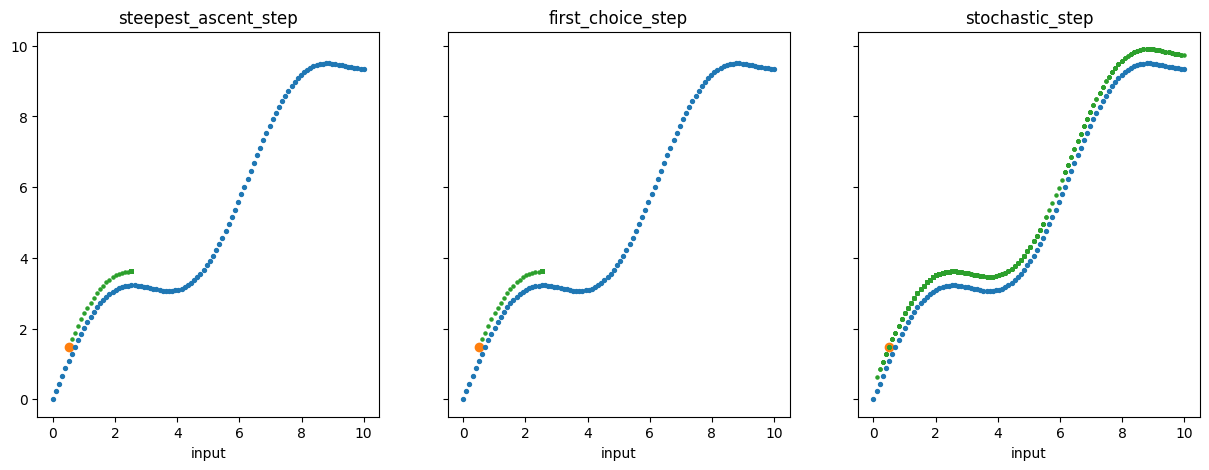

In [17]:
def f(x):
    return x+np.sin(x)*1.2

hill_climbing_variants = [steepest_ascent_step, first_choice_step, stochastic_step]
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

x = np.linspace(0, 10, 100)
y = f(x)

start_idx = 5
num_iters = 5000

for ax, optim in zip(axes, hill_climbing_variants):
    path = []
    current = start_idx
    for _ in range(num_iters):
        if current < 0 or current >= 99: break
        current = optim(current, y)
        path.append(current)

    ax.scatter(x[start_idx], y[start_idx]+.4, c='C1')
    ax.scatter(x[path], y[path]+.4, s=5, c='C2')
    ax.scatter(x, y, s=8, c='C0')
    ax.set_title(f"{optim.__name__}")
    ax.set_xlabel('input')

## Small intermezzo

Why is hill climbing very relevant in AI?

### Discrete vs Continuous

- **Discrete**: countable, e.g., the set of natural numbers $\mathbb{N}$ contains infinite numbers that are all countable.
    - $0, 1, 2, 3, 4, 5, \dots$
- **Continuous**: not countable, e.g., the set of real numbers $\mathbb{R}$ contains infinite numbers that are all uncountable 
    - $\dots, 0, 0.00000\dots, 0.00000\dots, \dots$

### From hill climbing (discrete) to gradient descent (continuous)

- Given a set of inputs (or states) $x_1, x_2, \dots, x_N$ that we may use in the objective function $f(x_1, x_2, \dots, x_N)$.
- In higher dimensions (high value for $N$), it becomes intractable to explore all possible neighbouring states of the input. 
- In this case, we can use the slope of the function $f$ to give us more information about the direction of steepest ascent.
- The gradient (or derivative) precisely gives us information about the slope of a function. 
- If the function is constant $y = c$, we get that the gradient is 0
- If the function is linear $y = ax + b$, we get that the gradient is $a$
- In all other cases we need to differentiate the function to find the gradient of steepest ascent, and use this to go a step upward or downward.

### How can we guarantee that steepest ascent will always give us a global optimum?

Given the graph for $y = -x^2$, for all pairs of points on the line, we draw a straight line between the pair of points: 
- if every possible line that we can draw by randomly taking a pair of points falls **under** the $y$ curve, then it is guaranteed that we will find a global maximum. The function is then called **convex**.
- if every possible line that we can draw by randomly taking a pair of points falls **above** the $y$ curve, then it is guaranteed that we will find a global minimum. The function is then called **concave**.

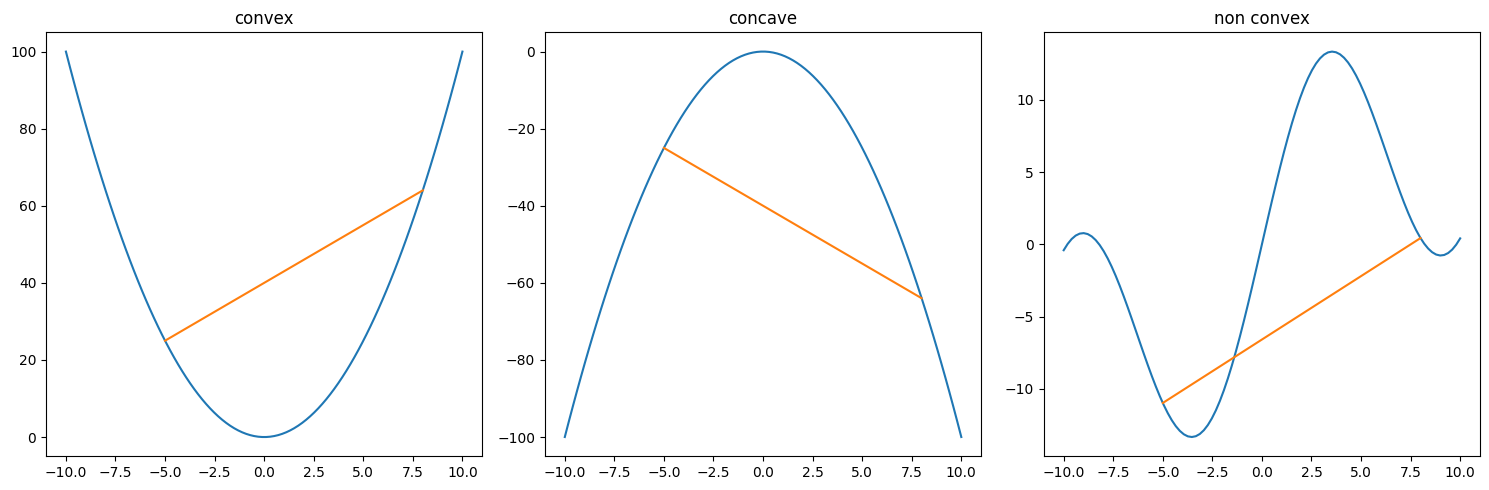

In [18]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-10, 10, 100)

convex = lambda x: x**2
concave = lambda x: -x**2
non_convex = lambda x: x+np.sin(x*.5)*10

funcs = [(convex, "convex"), (concave, 'concave'), (non_convex, "non convex")]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

xs = np.array([-5, 8])

for ax, (f, name) in zip(axes, funcs):

    ax.plot(x, f(x))
    ax.set_title(name)
    ax.plot(xs, f(xs))

plt.tight_layout()